In [1]:
# import os
# os.chdir('/Users/evanli/Documents/EvanPys/Progress/')

# from ADlasso2 import AD2_w_utils as ad
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import scipy
import sklearn
import copy
import importlib


In [ ]:
import scanpy as sc
import scvelo as scv

data = scv.datasets.pancreas(file_path='/Users/evanli/Documents/Research_datasets/PBMC_Hao/Hao_PBMC.h5ad')


In [5]:
label = data.obs['celltype.l2'].tolist()
types = np.unique(label).tolist()
cts = types[:12]
cts

['ASDC',
 'B intermediate',
 'B memory',
 'B naive',
 'CD14 Mono',
 'CD16 Mono',
 'CD4 CTL',
 'CD4 Naive',
 'CD4 Proliferating',
 'CD4 TCM',
 'CD4 TEM',
 'CD8 Naive']

## Read result_dict from json

In [6]:
!pwd

/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao/PBMC_AD2_result


In [14]:
import json

loss_dict = {}
opt_lambda_dict = {}
prevalence_dict = {}
for celltype in cts:
    print('Processing: ', celltype)
    # /Users/evanli/Documents/EvanPys/Progress/PBMC_Hao/PBMC_AD2_result/ASDC
    with open(f'./{celltype}/{celltype}_tuning.json') as f:
        result_dict = json.load(f)
    result_dict = {key: np.array(value) for key, value in result_dict.items()}

    # opt_lmbd, fig = ad.lambda_decision(result_dict, k=2)
    # opt_lambda_dict[celltype] = opt_lmbd
    # print('Optimal lambda: {}'.format(opt_lmbd))

    # Read optimal lambda
    with open(f'./{celltype}/{celltype}_opt_lambda.txt', 'r') as f:
        opt_lmbd = float(f.read())
    opt_lambda_dict[celltype] = opt_lmbd

    loss_dict[celltype] = result_dict['loss_history']
    prevalence_dict[celltype] = result_dict['Prevalence']

Processing:  ASDC
Processing:  B intermediate
Processing:  B memory
Processing:  B naive
Processing:  CD14 Mono
Processing:  CD16 Mono
Processing:  CD4 CTL
Processing:  CD4 Naive
Processing:  CD4 Proliferating
Processing:  CD4 TCM
Processing:  CD4 TEM
Processing:  CD8 Naive


In [15]:
opt_lambda_dict

{'ASDC': 0.046415888336127815,
 'B intermediate': 0.046415888336127815,
 'B memory': 0.06812920690579614,
 'B naive': 0.004641588833612781,
 'CD14 Mono': 0.004641588833612781,
 'CD16 Mono': 0.003162277660168382,
 'CD4 CTL': 0.046415888336127815,
 'CD4 Naive': 0.0021544346900318864,
 'CD4 Proliferating': 0.046415888336127815,
 'CD4 TCM': 0.0021544346900318864,
 'CD4 TEM': 0.06812920690579614,
 'CD8 Naive': 0.0014677992676220707}

In [9]:
# with open('./Pancreas_ADlasso/Pancreas_result/opt_lambda.json', 'w') as f:
#     json.dump(opt_lambda_dict, f)

## Plot summary loss vs. prevalance

In [10]:
log_lmbd_range = np.linspace(np.log(1e-4), np.log(1), 25)
lmbd_range = np.exp(log_lmbd_range)
print(lmbd_range)

[1.00000000e-04 1.46779927e-04 2.15443469e-04 3.16227766e-04
 4.64158883e-04 6.81292069e-04 1.00000000e-03 1.46779927e-03
 2.15443469e-03 3.16227766e-03 4.64158883e-03 6.81292069e-03
 1.00000000e-02 1.46779927e-02 2.15443469e-02 3.16227766e-02
 4.64158883e-02 6.81292069e-02 1.00000000e-01 1.46779927e-01
 2.15443469e-01 3.16227766e-01 4.64158883e-01 6.81292069e-01
 1.00000000e+00]


In [12]:
# create color palette for 8 cell types
import seaborn as sns

keys = list(loss_dict.keys())
palette = sns.color_palette('tab20', n_colors=len(keys))
color_dict = dict(zip(keys, palette))

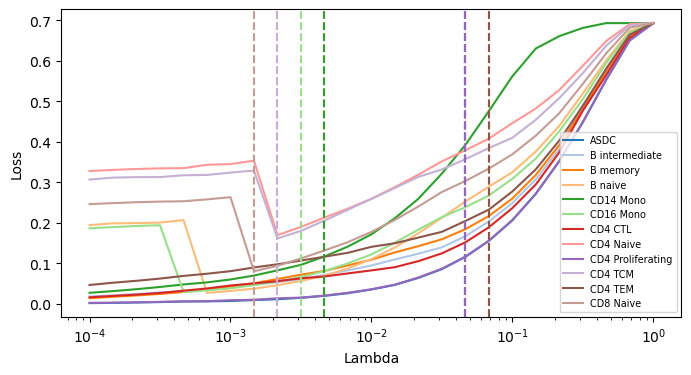

In [16]:
# Plot the loss history against lambda
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 4))

# plot the y-axis values for each key in loss_dict
for key in loss_dict:
    ax.plot(lmbd_range, loss_dict[key], label=key, color=color_dict[key])

# add vertical dotted lines at the values in opt_lambda_dict
for key in opt_lambda_dict:
    ax.axvline(x=opt_lambda_dict[key], linestyle='--', color=color_dict[key])

# set the x-axis label
ax.set_xlabel('Lambda')
ax.set_xscale('log')

# set the y-axis label
ax.set_ylabel('Loss')

# add a legend
ax.legend(loc='lower right', fontsize='x-small')

# show the plot
plt.show()

## Count feature number

In [30]:
for celltype in cts:
    feature_df = pd.read_csv(f'./{celltype}/{celltype}_features.txt', names=['Gene', 'Weight', 'Tendency'], sep='\t')
    print(celltype, 'Feature count:', feature_df.shape[0])
    print(celltype, 'Positive feature count:', feature_df[feature_df['Tendency'] == 1].shape[0])
    print('------------------')

ASDC Feature count: 1
ASDC Positive feature count: 0
------------------
B intermediate Feature count: 50
B intermediate Positive feature count: 0
------------------
B memory Feature count: 1
B memory Positive feature count: 0
------------------
B naive Feature count: 5
B naive Positive feature count: 3
------------------
CD14 Mono Feature count: 19
CD14 Mono Positive feature count: 9
------------------
CD16 Mono Feature count: 16
CD16 Mono Positive feature count: 8
------------------
CD4 CTL Feature count: 1
CD4 CTL Positive feature count: 0
------------------
CD4 Naive Feature count: 72
CD4 Naive Positive feature count: 35
------------------
CD4 Proliferating Feature count: 1
CD4 Proliferating Positive feature count: 0
------------------
CD4 TCM Feature count: 54
CD4 TCM Positive feature count: 29
------------------
CD4 TEM Feature count: 1
CD4 TEM Positive feature count: 0
------------------
CD8 Naive Feature count: 37
CD8 Naive Positive feature count: 16
------------------
